<a href="https://colab.research.google.com/github/kirillkobychev/HSE-ML-TEAM-4/blob/master/Project_Music_genre_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music genre prediction

**Описание задачи**

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса. Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

В ходе работы пройдите все основные этапы полноценного исследования:

*  загрузка и ознакомление с данными
*  предварительная обработка
*  полноценный разведочный анализ
*  разработка новых синтетических признаков
*  проверка на мультиколлинеарность
*  отбор финального набора обучающих признаков
*  выбор и обучение моделей
*  итоговая оценка качества предсказания лучшей модели
*  анализ важности ее признаков

**ВАЖНО**  
Необходимо реализовать решение с использованием технологии `pipeline` (из библиотеки `sklearn`)

**ОЖИДАЕМЫЙ РЕЗУЛЬТАТ**

* Оформленный репозиторий на GitHub (ноутбук с исследованием + код приложения)
* Развернутое web-приложение (с использованием библиотеки Streamlit)

## Участники проекта, репозиторий, приложение

Кобычев Кирилл, @hikoby

Иванов Егор, @Jaibesiondaide

Игорь Земенков, @iZemM

https://github.com/kirillkobychev/HSE-ML-TEAM-4

## Импорт библиотек, установка констант

In [92]:
%%capture
!pip install catboost -q
!pip install ydata-profiling
!pip install kaggle
!pip install --quiet tls-client tqdm

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier

from ydata_profiling import ProfileReport
import tls_client, difflib, time, random, re
import pandas as pd
from tqdm.auto import tqdm
from IPython.display import HTML

In [94]:
TRAIN = "https://www.dropbox.com/scl/fi/5zy935lqpaqr9lat76ung/music_genre_train.csv?rlkey=ccovu9ml8pfi9whk1ba26zdda&dl=1"
TEST = "https://www.dropbox.com/scl/fi/o6mvsowpp9r3k2lejuegt/music_genre_test.csv?rlkey=ac14ydue0rzlh880jwj3ebum4&dl=1"

In [95]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [141]:
# @title HTML
def display_card(title, value):
    html = f"""
    <div style='background-color: #f5f5f5; border-radius: 10px; padding: 20px; width: 200px; text-align: center; box-shadow: 0 4px 8px rgba(0,0,0,0.1);'>
        <p style='font-size: 14px; color: #888; margin: 0;'>{title}</p>
        <h1 style='font-size: 36px; color: #000; margin: 10px 0;'>{value}</h1>
    </div>
    """
    return html

# Функция для отображения карточек рядом
def display_flex_cards(cards):
    html = """
    <div style='display: flex; gap: 10px;'>
    """  # Изменено gap с 20px на 10px
    for title, value in cards:
        html += display_card(title, value)
    html += "</div>"
    return HTML(html)

## Загрузка и обзор данных

In [97]:
train = pd.read_csv(TRAIN)
test = pd.read_csv(TEST)

In [98]:
train.sample(5)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
9803,31298.0,More Than Anything,0.290,0.541,195093.0,0.498,0.000000,C#,0.2250,-7.664,Major,0.0273,NaN,4-Apr,0.136,Alternative
9988,48866.0,Lovely,0.579,0.489,291449.0,0.503,0.000626,NaN,0.6190,-9.001,Minor,0.0464,143.977,3-Apr,0.130,Alternative
16832,67084.0,Part of Me,0.434,0.679,246573.0,0.608,0.000013,G,0.0942,-8.334,Major,0.0340,111.803,4-Apr,0.735,Blues
11921,74490.0,The Rain (Supa Dupa Fly),0.117,0.854,246173.0,0.580,0.004710,C#,0.0921,-10.008,NaN,0.2170,162.116,4-Apr,0.700,Rap
5474,84061.0,Skokiaan,0.337,0.500,349827.0,0.623,0.006080,D#,0.6890,-9.083,Major,0.1490,99.493,4-Apr,0.721,Jazz


**Описание полей данных**

`instance_id` - уникальный идентификатор трека  
`track_name` - название трека  
`acousticness` - акустичность  
`danceability` - танцевальность  
`duration_ms` -продолжительность в милисекундах  
`energy` - энергичность  
`instrumentalness` - инструментальность  
**`key` - тональность**  
`liveness` - привлекательность  
`loudness` - громкость  
**`mode` - наклонение**  
`speechiness` - выразительность  
**`tempo` - темп**  
`obtained_date` - дата загрузки в сервис  
`valence` - привлекательность произведения для пользователей сервиса  
`music_genre` - музыкальный жанр

## Предварительная обработка данных

In [99]:
train.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative


In [100]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [101]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


In [102]:
print("Train unique")
[print(f"{i}: {train[i].unique()}") for i in train.columns if train[i].dtype == 'object']
print("\nTest unique")
[print(f"{i}: {test[i].unique()}") for i in test.columns if test[i].dtype == 'object']

Train unique
track_name: ['Highwayman' 'Toes Across The Floor' 'First Person on Earth' ...
 'Original Prankster' '4Peat' 'Trouble (feat. MC Spyder)']
key: ['D' 'A' 'E' 'G#' 'C' 'D#' 'A#' 'F' 'F#' nan 'G' 'C#' 'B']
mode: ['Major' 'Minor' nan]
obtained_date: ['4-Apr' '3-Apr' '5-Apr' '1-Apr']
music_genre: ['Country' 'Rock' 'Alternative' 'Hip-Hop' 'Blues' 'Jazz' 'Electronic'
 'Anime' 'Rap' 'Classical']

Test unique
track_name: ['Low Class Conspiracy' 'The Hunter' 'Hate Me Now' ... 'Bipolar'
 'Dead - NGHTMRE Remix'
 'A Night In Tunisia - Remastered 1998 / Rudy Van Gelder Edition']
key: ['A#' 'G#' 'A' 'B' 'D' 'F#' 'F' 'G' 'C' nan 'D#' 'C#' 'E']
mode: ['Minor' 'Major' nan]
obtained_date: ['4-Apr' '3-Apr' '5-Apr' '1-Apr']


[None, None, None, None]

In [103]:
print("Train null")
[print(f"{i} ({train[i].dtype}): {train[i].isnull().sum()}") for i in train.columns if train[i].isnull().sum() > 0]
print("Train data shape:", train.shape)
print("\nTest null")
[print(f"{i} ({test[i].dtype}): {test[i].isnull().sum()}") for i in test.columns if test[i].isnull().sum() > 0]
print("Test data shape: ", test.shape)

Train null
key (object): 735
mode (object): 506
tempo (float64): 442
Train data shape: (20394, 16)

Test null
key (object): 158
mode (object): 149
tempo (float64): 121
Test data shape:  (5099, 15)


Заполняем пропуски с помощью сервиса Tunebat, который имеет доступ к API Spotify. Парсим данные признаков: {"key"; "mode"; "tempo"} к каждой композиции. Время выполнения ячейки ниже занимает ~3 часа, при этом мы не избавляемся от пропусков, а заполняем их. Код ниже добавлен в комментарий, а новые csv файлы после обработки были сохранены ниже на Dropbox: (TRAIN_FILLED & TEST_FILLED)

*   Train: пропуски ПОСЛЕ {'key': 28, 'mode': 16, 'tempo': 15}
*   Test: пропуски ПОСЛЕ {'key': 2, 'mode': 8, 'tempo': 4}

* Остаток пропусков в конце удаляем

In [104]:
# @title Заполнение пропусков
# df_train = train.copy(deep=True)
# df_test  = test.copy(deep=True)

# BASE_URL   = "https://api.tunebat.com/api/tracks/search"
# KEY_LIST   = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
# PAUSE_SEC  = (0.4, 0.8)
# session    = tls_client.Session(client_identifier="chrome_124",
#                                 random_tls_extension_order=True)

# FLAT2SHARP = {'AB':'G#','BB':'A#','CB':'B',
#               'DB':'C#','EB':'D#','FB':'E','GB':'F#'}

# def normalize_key(raw: str | None):
#     if not isinstance(raw, str):
#         return None

#     m = re.match(r'^\s*([A-Ga-g])([#♯b♭]?)(?:\s|$)', raw)
#     if not m:
#         return None

#     letter, accidental = m.groups()
#     note = (letter.upper() +
#             {'#': '#', '♯': '#', 'b': 'B', '♭': 'B'}.get(accidental, ''))

#     if len(note) == 2 and note[1] == 'B':
#         note = FLAT2SHARP.get(note, None)

#     return note if note in KEY_LIST else None

# def camelot_to_mode(cam):
#     return ("Minor" if cam and cam[-1]=='A' else "Major") if cam else None

# def tunebat_search(query, score_threshold=0.80):
#     time.sleep(random.uniform(*PAUSE_SEC))
#     r = session.get(BASE_URL, params={"term": query})

#     if r.status_code == 429:
#         time.sleep(int(r.headers.get("Retry-After", "5")) + 1)
#         r = session.get(BASE_URL, params={"term": query})

#     if r.status_code != 200:
#         return None

#     items = r.json().get("data", {}).get("items", [])
#     if not items:
#         return None

#     best = max(items, key=lambda d:
#                difflib.SequenceMatcher(None, d["n"].lower(), query.lower()).ratio())
#     if difflib.SequenceMatcher(None, best["n"].lower(), query.lower()).ratio() < score_threshold:
#         return None
#     return best

# cache = {}
# def get_info(track):
#     if track not in cache:
#         cache[track] = tunebat_search(track)
#     return cache[track]

# def fill_missing(df: pd.DataFrame, name: str):
#     print(f"\n{name}: пропуски ДО", df[['key','mode','tempo']].isna().sum().to_dict())

#     for col in ['key', 'mode', 'tempo']:
#         for idx in tqdm(df[df[col].isna()].index, desc=f"{name}: заполняем {col}"):
#             track = str(df.at[idx, 'track_name']).strip()
#             info  = get_info(track)
#             if not info:
#                 continue

#             key_new  = normalize_key(info.get('k'))
#             mode_new = camelot_to_mode(info.get('c'))
#             bpm      = info.get('b')

#             if pd.isna(df.at[idx,'key'])  and key_new:
#                 df.at[idx,'key'] = key_new
#             if pd.isna(df.at[idx,'mode']) and mode_new:
#                 df.at[idx,'mode'] = mode_new
#             if pd.isna(df.at[idx,'tempo']) and bpm:
#                 try: df.at[idx,'tempo'] = float(bpm)
#                 except (ValueError, TypeError): pass

#             tqdm.write(f"{track} → key:{key_new} mode:{mode_new} tempo:{bpm}")

#     print(f"{name}: пропуски ПОСЛЕ", df[['key','mode','tempo']].isna().sum().to_dict())
#     print(f"{name} shape: {df.shape}\n")

# fill_missing(df_train, "Train")
# fill_missing(df_test,  "Test")

# df_train_filled = df_train.copy()
# df_test_filled  = df_test.copy()
# df_train_filled.to_csv('df_train_filled.csv', index=False)
# df_test_filled.to_csv('df_test_filled.csv',  index=False)

# print("\nnew filled df: df_train_filled.csv, df_test_filled.csv")
# print("unique key :", sorted(df_train_filled['key'].dropna().unique()))
# print("unique mode:", sorted(df_train_filled['mode'].dropna().unique()))

In [105]:
TRAIN_FILLED = (
    "https://www.dropbox.com/scl/fi/b15tvwr1uv7b3yx3dqvhq/df_train_filled.csv"
    "?rlkey=m2bowu7cjpqijyp4venzv1ncs&st=jix0z39a&dl=1"
)
TEST_FILLED = (
    "https://www.dropbox.com/scl/fi/kwpslwi5sq6bw1ci6a1z8/df_test_filled.csv"
    "?rlkey=9n3fjlxgktdzi8ecdghegi97f&st=uqp8ph6x&dl=1"
)

In [106]:
train_filled = pd.read_csv(TRAIN_FILLED)
test_filled = pd.read_csv(TEST_FILLED)

In [107]:
columns_to_check = ["key", "mode", "tempo"]

train_filled = train_filled.dropna(subset=columns_to_check)
train_filled = train_filled[~((train_filled[columns_to_check] == 0).any(axis=1))]
test_filled = test_filled.dropna(subset=columns_to_check)
test_filled = test_filled[~((test_filled[columns_to_check] == 0).any(axis=1))]

In [108]:
columns_to_drop = [train_filled.columns[0], "instance_id", "obtained_date"]

train_filled = train_filled.drop(columns=columns_to_drop, errors='ignore')
test_filled = test_filled.drop(columns=columns_to_drop, errors='ignore')

## Разведочный анализ

Размер датасета (Test)

In [143]:
# @title Размер датасета Train и Test
train_filled_img = train_filled.shape
test_filled_img = test_filled.shape
cards = [
    ("TRAIN: Строк и столбцов", f"{train_filled_img[0]} x {train_filled_img[1]}"),
    ("TEST: Строк и столбцов", f"{test_filled_img[0]} x {test_filled_img[1]}")
]

# Отображение карточек рядом
display_flex_cards(cards)

In [111]:
train_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20335 entries, 0 to 20393
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        20335 non-null  object 
 1   acousticness      20335 non-null  float64
 2   danceability      20335 non-null  float64
 3   duration_ms       20335 non-null  float64
 4   energy            20335 non-null  float64
 5   instrumentalness  20335 non-null  float64
 6   key               20335 non-null  object 
 7   liveness          20335 non-null  float64
 8   loudness          20335 non-null  float64
 9   mode              20335 non-null  object 
 10  speechiness       20335 non-null  float64
 11  tempo             20335 non-null  float64
 12  valence           20335 non-null  float64
 13  music_genre       20335 non-null  object 
dtypes: float64(10), object(4)
memory usage: 2.3+ MB


In [112]:
test_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5085 entries, 0 to 5098
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        5085 non-null   object 
 1   acousticness      5085 non-null   float64
 2   danceability      5085 non-null   float64
 3   duration_ms       5085 non-null   float64
 4   energy            5085 non-null   float64
 5   instrumentalness  5085 non-null   float64
 6   key               5085 non-null   object 
 7   liveness          5085 non-null   float64
 8   loudness          5085 non-null   float64
 9   mode              5085 non-null   object 
 10  speechiness       5085 non-null   float64
 11  tempo             5085 non-null   float64
 12  valence           5085 non-null   float64
dtypes: float64(10), object(3)
memory usage: 556.2+ KB


In [113]:
train_filled.describe().T

,count,mean,std,min,25%,50%,75%,max
acousticness,20335.0,0.274803,0.321640,0.00000,0.0152,0.120000,0.4700,0.996
danceability,20335.0,0.561993,0.171915,0.06000,0.4510,0.570000,0.6830,0.978
duration_ms,20335.0,220366.680157,126766.348585,-1.00000,177526.5000,219507.000000,265953.0000,4497994.000
energy,20335.0,0.625249,0.251230,0.00101,0.4700,0.666000,0.8300,0.999
instrumentalness,20335.0,0.159920,0.306434,0.00000,0.0000,0.000145,0.0844,0.996
liveness,20335.0,0.198519,0.166749,0.01360,0.0973,0.130000,0.2520,1.000
loudness,20335.0,-8.553347,5.497710,-44.40600,-10.2570,-7.052000,-5.0540,3.744
speechiness,20335.0,0.091351,0.097756,0.02230,0.0356,0.049000,0.0956,0.942
tempo,20335.0,120.965805,30.412755,34.76500,95.9520,120.015000,141.9785,220.041
valence,20335.0,0.464560,0.243369,0.00000,0.2720,0.457000,0.6530,0.992


In [114]:
test_filled.describe().T

,count,mean,std,min,25%,50%,75%,max
acousticness,5085.0,0.276847,0.322875,0.000002,0.0166,0.121000,0.4620,0.996
danceability,5085.0,0.561940,0.170638,0.059600,0.4510,0.569000,0.6810,0.977
duration_ms,5085.0,217309.374435,115695.925728,-1.000000,173693.0000,217413.000000,264080.0000,1360027.000
energy,5085.0,0.621780,0.252004,0.001540,0.4650,0.660000,0.8260,0.999
instrumentalness,5085.0,0.164563,0.311393,0.000000,0.0000,0.000156,0.0919,0.994
liveness,5085.0,0.197918,0.166286,0.020400,0.0970,0.129000,0.2480,0.990
loudness,5085.0,-8.634324,5.624981,-46.122000,-10.2330,-7.135000,-5.1240,1.949
speechiness,5085.0,0.092775,0.100190,0.022600,0.0357,0.048700,0.0968,0.918
tempo,5085.0,121.181906,29.896092,37.114000,96.0200,120.037000,141.9110,216.029
valence,5085.0,0.465455,0.244096,0.020500,0.2720,0.458000,0.6490,0.982


In [115]:
train_filled.describe(include='object').T

,count,unique,top,freq
track_name,20335,18591,Home,11
key,20335,12,G,2374
mode,20335,2,Major,13110
music_genre,20335,10,Blues,2853


In [116]:
test_filled.describe(include='object').T

,count,unique,top,freq
track_name,5085,4967,Sorry,3
key,5085,12,D,570
mode,5085,2,Major,3265


In [117]:
train_filled.duplicated().sum()

np.int64(1)

In [118]:
test_filled.duplicated().sum()

np.int64(32)

In [119]:
%%capture
profile_train = ProfileReport(train_filled, title="Profiling Report")
profile_train.to_file("train_filled.html")

profile_test = ProfileReport(test_filled, title="Profiling Report")
profile_test.to_file("test_filled.html")

Баланс классов

In [120]:
train_filled['music_genre'].value_counts(normalize=True)

,proportion
music_genre,
Blues,0.140300
Alternative,0.127760
Electronic,0.125645
Rap,0.119203
Rock,0.106024
Country,0.104057
Anime,0.092648
Classical,0.067273
Jazz,0.060880




> Явного доминирующего класса нет, но разброс почти в 3 раза между Blues и Hip-Hop.



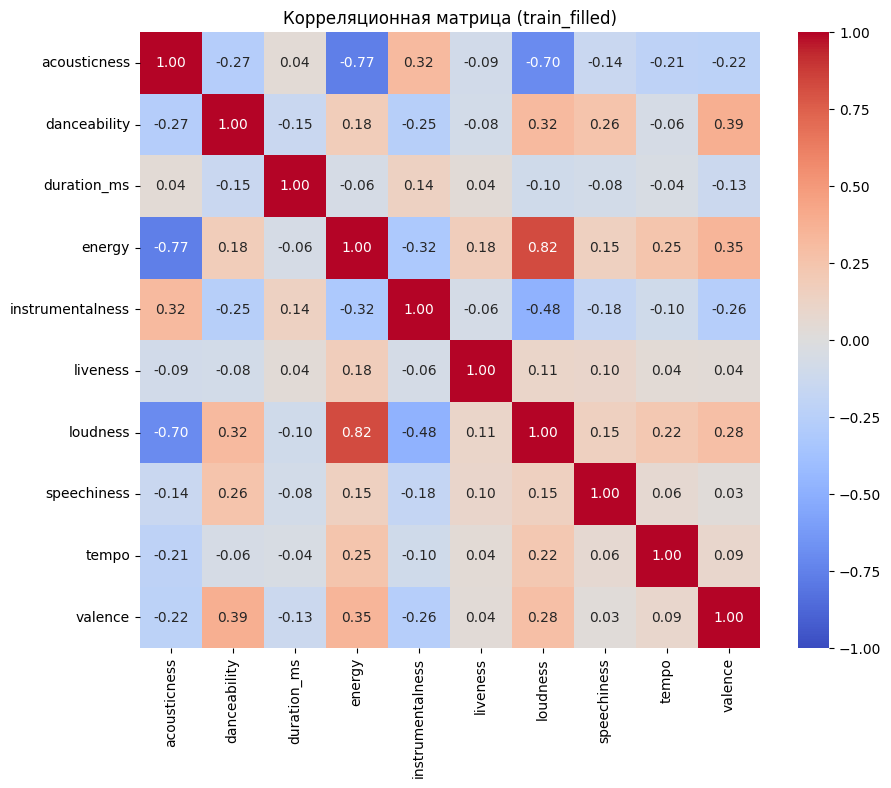

In [124]:
# @title Корреляционная матрица (train_filled)
numeric_cols_train = train_filled.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = train_filled[numeric_cols_train].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Корреляционная матрица (train_filled)')
plt.show()

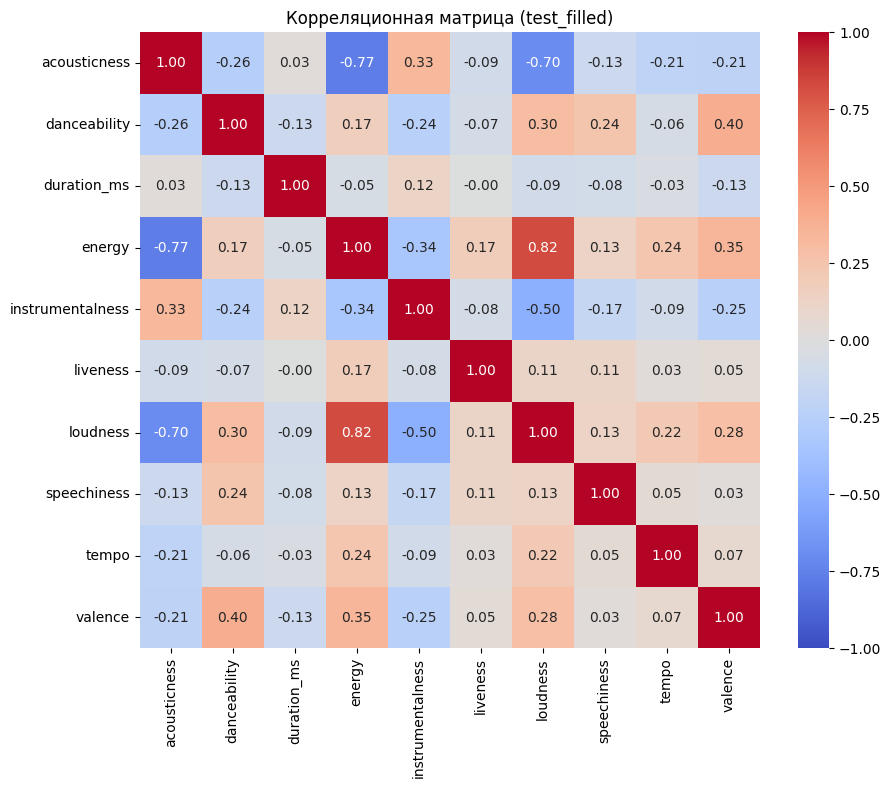

In [125]:
# @title Корреляционная матрица (test_filled)
numeric_cols_test = test_filled.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = test_filled[numeric_cols_test].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Корреляционная матрица (test_filled)')
plt.show()



> 1. Energy & Loudness (Train 0,82 | Test 0,82)


> 2. Acousticness & Energy (Train -0.77 | Test -0.77)


> 3. Acousticness & Loudness (Train -0.70 | Test	-0.70)







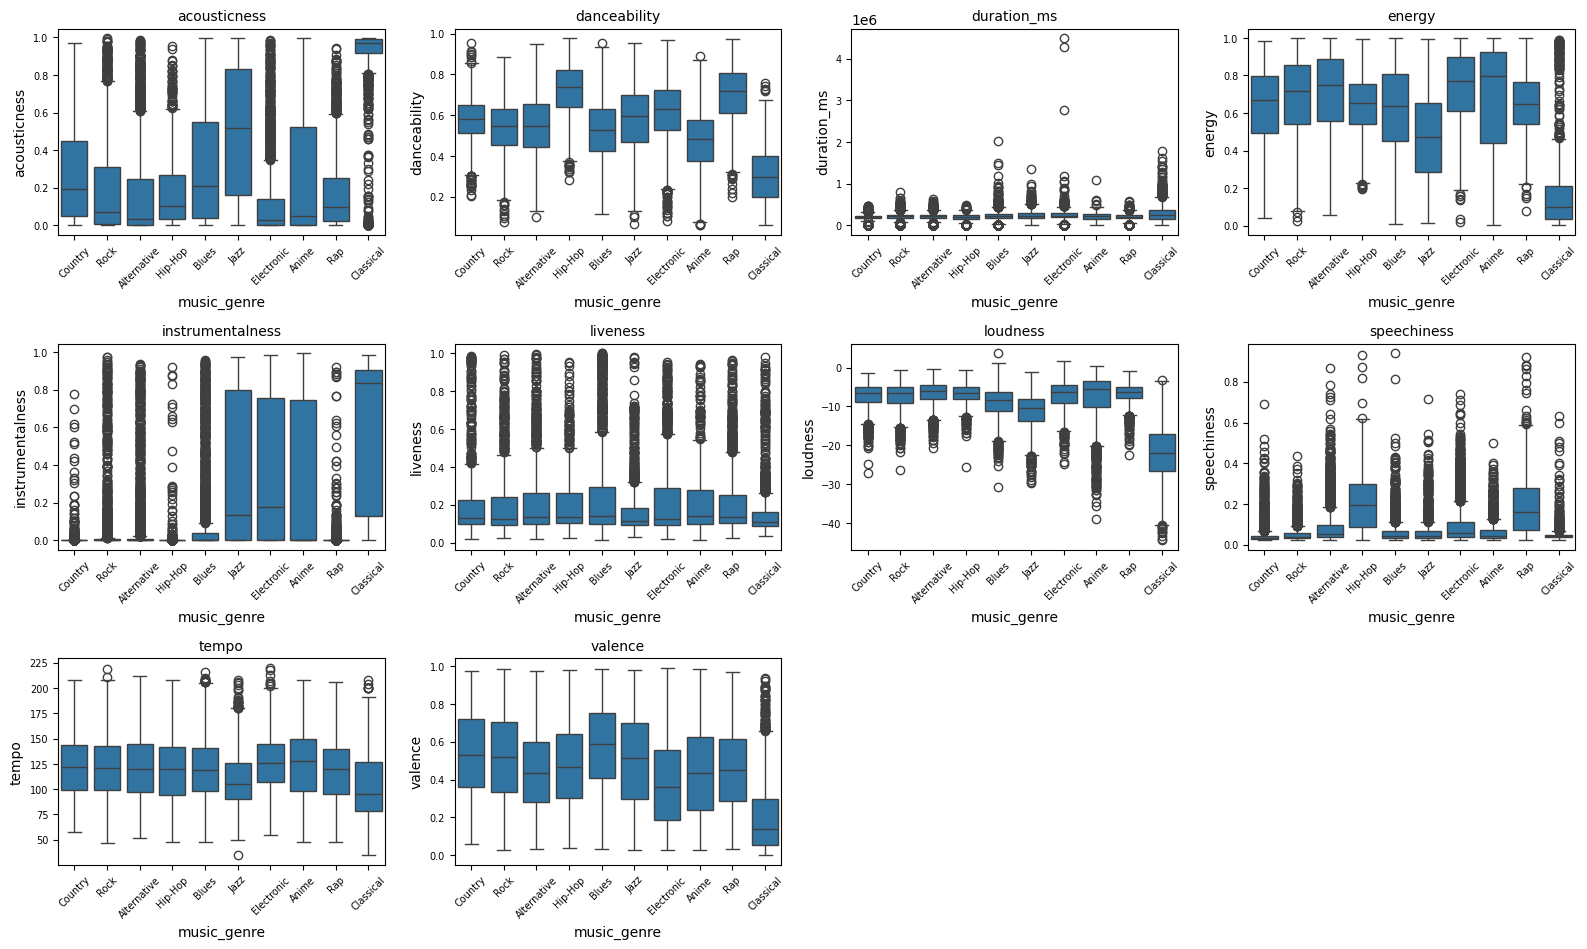

In [126]:
# @title Как признаки различают жанры
numeric_cols = train_filled.select_dtypes(include='number').columns.difference(['music_genre']).tolist()

n_plots = len(numeric_cols)
side = math.ceil(math.sqrt(n_plots))

fig, axes = plt.subplots(side, side, figsize=(side*4, side*3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    sns.boxplot(data=train_filled, x='music_genre', y=col, ax=ax)
    ax.set_title(col, fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=7)
    ax.tick_params(axis='y', labelsize=7)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Сильные признаки**

> 1. speechiness


> 2. instrumentalness


> 3. acousticness







## Работа с признаками

## Выбор и обучение моделей

## Оценка качества

## Анализ важности признаков модели